### Clusterizando clientes

In [28]:
#Carregando bibliotecas
import pandas as pd
from sklearn.cluster import KMeans

#Lendo bases de dados:
pedidos = pd.read_csv(r'C:\Users\elise\OneDrive\Área de Trabalho\olist\olist_orders_dataset.csv')
clientes = pd.read_csv(r'C:\Users\elise\OneDrive\Área de Trabalho\olist\olist_customers_dataset.csv')
itens = pd.read_csv(r'C:\Users\elise\OneDrive\Área de Trabalho\olist\olist_order_items_dataset.csv')
produtos = pd.read_csv(r'C:\Users\elise\OneDrive\Área de Trabalho\olist\olist_products_dataset.csv')

### Vamos agrupar dados relevantes das nossas bases de dados

In [29]:
#Temos diversas informações espalhadas pelas bases de dados. A ideia é compilar as informações e consultá-las de forma mais rápida
pedidos_clientes = pedidos.merge(on = 'customer_id', right = clientes)[['order_id', 'customer_id', 'customer_unique_id', 'customer_city', 'customer_state']]
pedidos_clientes = pedidos_clientes.merge(on = 'order_id', right = itens)[['order_id', 'customer_id', 'customer_unique_id', 'customer_city', 'customer_state', 'product_id', 'price', 'freight_value']]
pedidos_clientes = pedidos_clientes.merge(on = 'product_id', right = produtos)[['order_id', 'customer_unique_id', 'customer_city', 'customer_state', 'product_id', 'price', 'freight_value', 'product_category_name']]

In [30]:
#Vamos começar a manipular a base de pedidos para aplicar o algoritmo
gasto_cliente = pedidos_clientes.groupby('customer_unique_id')['price'].sum()
clientes_id = gasto_cliente.reset_index()['customer_unique_id'].copy()
gasto_cliente = gasto_cliente.values.reshape(-1, 1)
gasto_cliente = pd.DataFrame(gasto_cliente, columns = ['price'])

In [31]:
#Fazendo as classificações
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(gasto_cliente)

# Determinando os clusters e inserindo na tabela
gasto_cliente['cluster'] = kmeans.labels_

gasto_cliente['customer_unique_id'] = clientes_id.copy()
gasto_cliente = gasto_cliente[['customer_unique_id', 'price', 'cluster']]

### Vamos explorar nossos dados em função dos agrupamentos

<AxesSubplot:title={'center':'Receita média por Cliente'}, xlabel='cluster'>

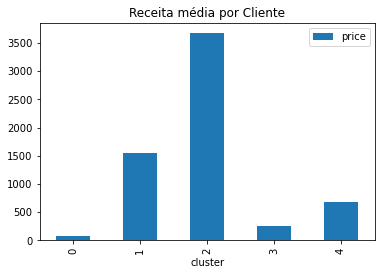

In [32]:
#Aqui temos a média de Receita para cada cluster
#Podemos perceber que o grupo com maior receita média por cliente é o Cluster 2
pd.DataFrame(round(gasto_cliente.groupby('cluster')['price'].mean(), 2)).plot(kind = 'bar', title = 'Receita média por Cliente')

<AxesSubplot:title={'center':'Receita total por Cluster'}, xlabel='cluster'>

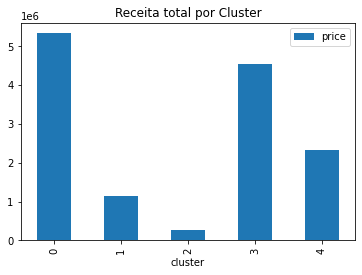

In [33]:
pd.DataFrame(round(gasto_cliente.groupby('cluster')['price'].sum(), 2)).plot(kind = 'bar', title = 'Receita total por Cluster')

In [34]:
resumo = gasto_cliente.groupby('cluster')['price'].sum().reset_index()
resumo = resumo.rename({'price': 'Receita'}, axis = 1)
resumo = resumo.merge(right = gasto_cliente.groupby('cluster').count().reset_index(), on = 'cluster').drop(columns = 'price').rename({'customer_unique_id': 'Qnt_Clientes'}, axis = 1)
resumo['Média'] = round(resumo.Receita / resumo.Qnt_Clientes, 2)

<AxesSubplot:ylabel='Qnt_Clientes'>

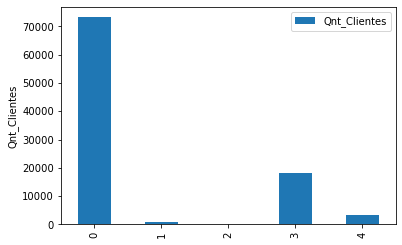

In [35]:
resumo.plot(y = 'Qnt_Clientes', kind = 'bar', ylabel = 'Qnt_Clientes')

In [36]:
percentual = []
for i in range(0, len(resumo)):
    percentual.append(str(round(resumo.Qnt_Clientes[i]/resumo.Qnt_Clientes.sum()*100,2)) + '%')
resumo['% Clientes'] = percentual
    
percentual = []
for i in range(0, len(resumo)):
    percentual.append(str(round(resumo.Receita[i]/resumo.Receita.sum()*100,2)) + '%')
resumo['% Receita'] = percentual

resumo

,cluster,Receita,Qnt_Clientes,Média,% Clientes,% Receita
0,0,5334526.25,73191,72.89,76.7%,39.25%
1,1,1136528.76,731,1554.76,0.77%,8.36%
2,2,267863.75,73,3669.37,0.08%,1.97%
3,3,4535384.71,18029,251.56,18.89%,33.37%
4,4,2317340.23,3396,682.37,3.56%,17.05%
